# KNN - Caso Titanic

En este notebook, utilizaremos K-Nearest Neighbor para entrenar un algoritmo de clasificación que permita establecer un modelo que prediga los sobrevivientes del dataset Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Análisis Exploratorio

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


<Axes: xlabel='Survived', ylabel='count'>

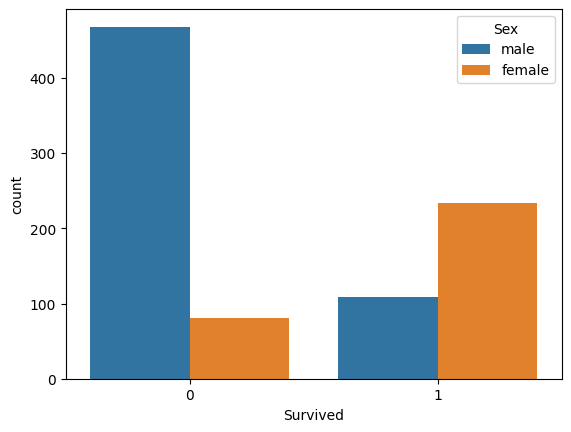

In [4]:
sns.countplot(x="Survived", hue="Sex", data=df)

<Axes: xlabel='Survived', ylabel='count'>

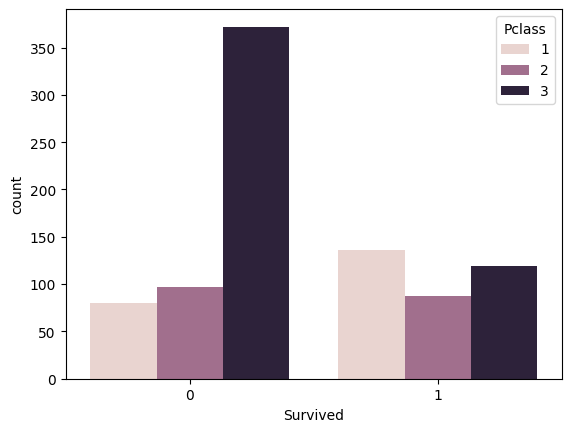

In [5]:
sns.countplot(x="Survived", hue="Pclass", data=df)

### Valores perdidos

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

La cabina no aporta mucho en el análisis, pero la edad es una variable importante para predecir si una persona sobrevivió o no a la trajedia. A continuación, una forma de "visualizar" los valores perdidos.

<Axes: >

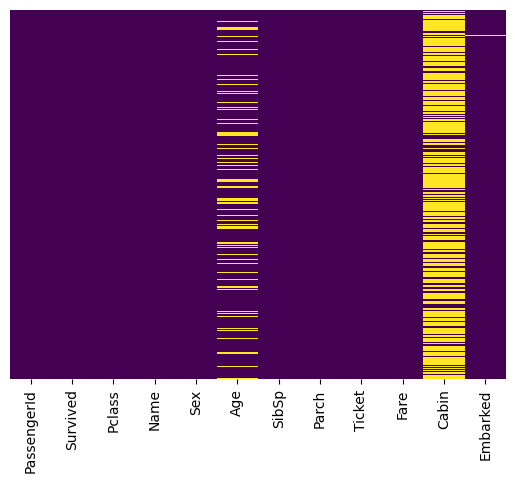

In [7]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Haremos una imputación de la edad del pasajero en función del promedio de edad de la clase en la que viajaba.

<Axes: xlabel='Pclass', ylabel='Age'>

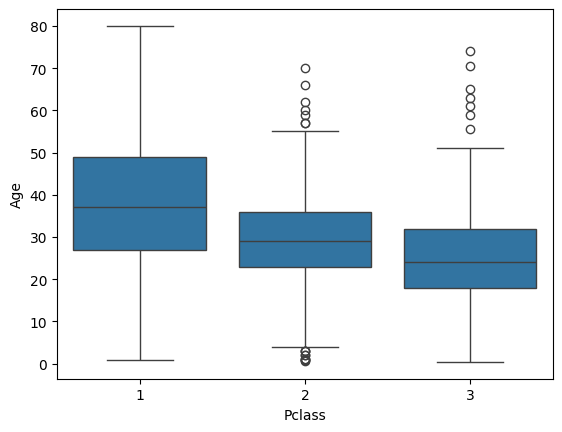

In [8]:
sns.boxplot(x='Pclass', y='Age', data=df)

In [9]:
#edades = round(df.groupby('Pclass').mean()['Age'])
edades = df.groupby('Pclass')['Age'].mean().round()
edades


Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [10]:
# creamos una funcion que imputa la edad en caso de estar nula
def imputar_edad(cols):
    edad = cols[0]
    pclass = cols[1]
    if(pd.isnull(edad)):
        if(pclass==1):
            return 38
        if(pclass==2):
            return 30
        if(pclass==3):
            return 25
    else:
        return edad

In [11]:
df['Age'] = df[['Age','Pclass']].apply(imputar_edad, axis=1)

C:\Users\adria\AppData\Local\Temp\ipykernel_48000\3628055789.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edad = cols[0]
C:\Users\adria\AppData\Local\Temp\ipykernel_48000\3628055789.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pclass = cols[1]


In [12]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Formulación del modelo

En esta sección seleccionaremos las variables que incorporaremos en la matriz de predictores "X" y en el vector de resultados "y", ya que no todas las columnas son de utilidad.

In [13]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived'] 

### Tratamiento de variables categoricas

La variable Embarked es categórica, debemos transformarla en variable dummy para incorporarla en el modelo.

In [14]:
X.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [16]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})  # Convert to binary
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'] + [col for col in df.columns if 'Embarked' in col]]
y = df['Survived']

### Escalamiento de Features

In [17]:
scaler = StandardScaler()

In [18]:
X_scaled = scaler.fit_transform(X)

### Validación cruzada

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 101, stratify=y)

### Entrenamiento del algoritmo K_NN

In [20]:
k_range = range(1, 50)
k_scores = []
error_rates = []


for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    knn.fit(X_train, y_train)  # Train the model
    y_pred = knn.predict(X_test)  # Predict the results of the test set
    error_rate = np.mean(y_pred != y_test)  # Calculate error rate
    error_rates.append(error_rate)

### Determinación del valor de K

In [ ]:
optimal_k = k_range[np.argmax(k_scores)]
print(f"Optimal value of K: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

'''Otra forma de enconntrar k es probando varios valores posibles y evaluando el desempeño con el conjunto de prueba.'''
'''k_range = range(1, 50)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]  # k con mayor accuracy promedio
print(f"Optimal value of K: {optimal_k}")'''


Optimal value of K: 8
Optimal value of K: 8


In [22]:
# Evaluate the model
accuracy = knn.score(X_test, y_test)
print(f"Accuracy of the KNN model with K={optimal_k}: {accuracy:.2f}")

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

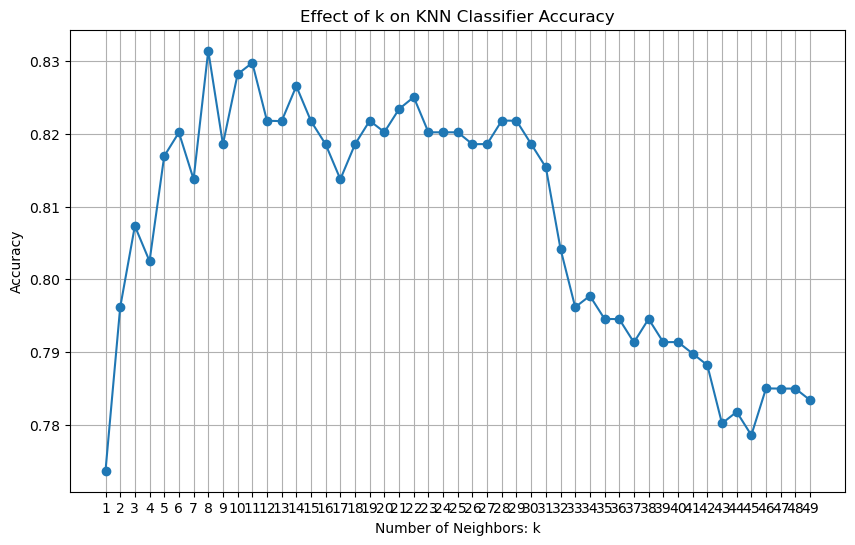

In [ ]:
# Plotting k values against accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.title('Effect of k on KNN Classifier Accuracy')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(k_range)
plt.show()

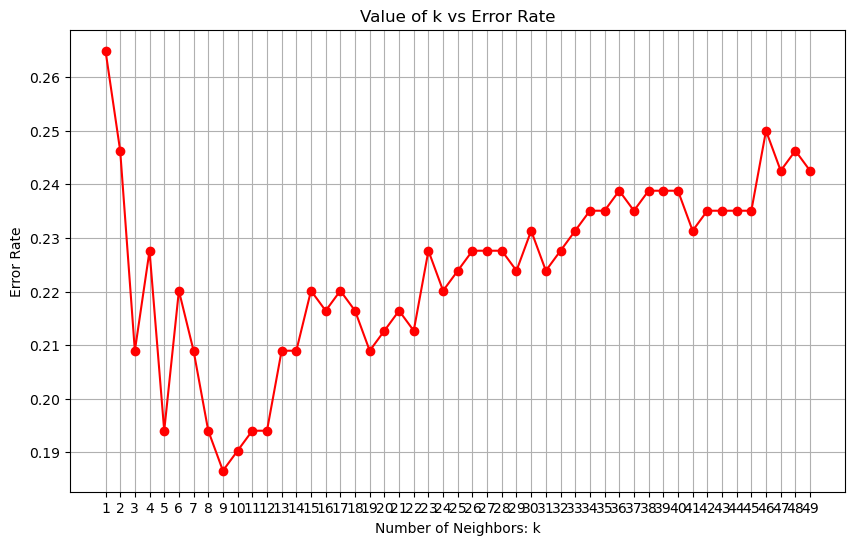

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rates, marker='o', linestyle='-', color='r')
plt.title('Value of k vs Error Rate')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Error Rate')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
k_range = range(1, 50)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Train the model
    y_pred = knn.predict(X_test)  # Predict the results of the test set
    error_rate = np.mean(y_pred != y_test)  # Calculate error rate
    error_rates.append(error_rate)

# Determine the optimal k (minimizing error)
optimal_k = k_range[np.argmin(error_rates)]
print(f"Optimal number of neighbors (k) with minimal error: {optimal_k}")


Optimal number of neighbors (k) with minimal error: 9
